In [3]:
# Now combine the work of One Period and No Hodlers; have multiple periods where if we are in the high state, 
# we may keep growing next period, while in the low state, we stop growing but also add hodlers to population.

# Set U(X)=X; u(q)=((q+b)**(1-eta)-b**eta)/(1-eta) or u(q)=ln(q+b)-ln(b) if eta = 1; c(q)=q 
# So u'=(q+b)**-eta; c'=1; z(q)=(1-theta)u(q)+theta*c(q); z'=(1-theta)*(q+b)**(-eta)+theta;
# l=theta*(u'(q)-c'(q))/z'(q)
# l=theta*((q+b)**(-eta)-1)/((1-theta)*(q+b)**(-eta)+theta)=theta*(1-(q-b)**eta)/(1-theta*(1-(q+b)**eta))
import math
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from numba import jit, vectorize
import math
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from IPython.core.debugger import set_trace
file = r'C:\Users\spspi\Dropbox\Documents\Cryptocurrency Project\Simulations' #Save simulation graphs here
B = .95 # Discount rate beta
# b = .00001 # This is part of utility function, makes it steep around 0
# lam = .75 # Meeting rate lamcda
# theta = .75 # Buyer bargaining power
# eta = .75 # Buyer risk aversion
b = .00001 # This is part of utility function (trying to get W to be increasing in alpha)
lam = .5 # Meeting rate lamcda (trying to get W to be increasing in alpha)
theta = .5 # Buyer bargaining power (trying to get W to be increasing in alpha)
eta = .3 # Buyer risk aversion (trying to get W to be increasing in alpha)
gammam = 0.02 # Money inflation rate
gammac = 0 # c inflation rate
qstar = 1 - b # Value at which u'=c'

# First, need to find steady state prices. Assume enite wealth always spent.
# phi/(phi'B)-1=(1+gammam)/B=i_m=lamc*l(phi'm'+psi'c')+lamm*l(phi'm')=lamc*l(qc)+lamm*l(gm)
# psi/(psi'B)-1=(1+gammac)/B=i_c=lamc*l(phi'm'+psi'c')=lamm*l(qc)

# Create a function that finds tomorrow's q's in stst
def ststq(alpha, Mp, Cp, gammam = gammam, gammac=gammac, lam=lam, theta=theta, eta=eta):
    lamc = lam * alpha # Chance of crypto type meeting
    lamm = lam * (1 - alpha) # Chance of money type meeting
    if alpha > (gammac + 1 - B) / (gammam + 1 - B): # If c is valued, can solve these equations for q, because m=M in st st
        # crypto type meetings
        qc = np.minimum(np.maximum((np.maximum((theta * B * lamc - (1 - theta) * (1 + gammac - B)) / (theta*
                                             (1 + gammac - B + B * lamc)), 0)) ** (1 / eta) - b, 0), qstar)
        # Money type meetings
        qm=np.minimum(np.maximum((np.maximum((theta * B * lamm - (1 - theta) * (gammam - gammac))
                                          / (theta * (gammam - gammac + B * lamm)), 0)) ** (1 / eta) - b, 0), qstar)
        return qc, qm
    else: # If c not valued,then get same q in crypto meetings
        qm = np.minimum(np.maximum((np.maximum((theta * B * lam - (1 - theta) * (1 + gammam - B))/
                                               (theta * (1 + gammam - B + B * lam)), 0))**(1 / eta) - b, 0), qstar)
        return qm, qm

# Create a function that finds tomorrow's price in stst
def ststprices(alpha, Mp, Cp, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta):
    qc, qm=ststq(alpha, Mp, Cp, gammam, gammac, lam, theta, eta) # Find qc and qm from above
    if eta != 1: # If not ln utility
        # Tomorrow's price of money
        phip = (theta * qm + (1 - theta) * ((qm + b) ** (1 - eta) - b ** (1 - eta)) / (1 - eta)) / Mp
        # Tomorrow's price of c
        psip = (theta * (qc - qm) + (1 - theta) * ((qc + b) ** (1 - eta) - (qm + b) ** (1 - eta)) / (1 - eta)) / Cp
    else: # if ln utility
        # Tomorrow's price of money
        phip = (theta * qm + (1 - theta) * (np.log(qm + b) - np.log(b))) / Mp
        # Tomorrow's price of c
        psip = (theta * (qc - qm) + (1 - theta) * (np.log(qc + b) - np.log(qm + b))) / Cp
    return phip, psip    

# Create an explicit utility function so q is never negative
def u(q, eta=eta):
    q = np.array(q)
    if q < 0: # Don't want negative consumption
        return -1e6
    elif eta != 1: # If not ln utility
        return ((q + b) ** (1 - eta) - b ** (1 - eta)) / (1 - eta)
    else: # if ln utility
        return np.log(qstar + b) - np.log(b)
    
def du(q, eta=eta):
    q = np.array(q)
    if q < 0: # If negative, no slope
        return 0
    else: 
        return (q + b) ** (-eta)
    
# Create a function that outputs z(q(w))=w for a given wealth w and q (solve by giving a w, set this equal to 0, and solve for q)
def wminz(q, w, theta=theta, eta=eta):
    return w - theta * q - (1 - theta) * u(q, eta)

# Create a function to take the derivative of z
def dz(q, theta=theta, eta=eta):
    q = np.array(q)
    if q < 0:
        return 0
    if q >= qstar:
        return 0
    else:
        return theta + (1 - theta) * (q + b) ** (-eta)
    
# Create a function to solve for q given w, this time with bisect (sensitive to first guess)
def qwealth(w, theta=theta, eta=eta):
    w = np.array(w)
    if w > 0:
        q = optimize.brentq(wminz, -1e20, 1e20, args=(w, theta, eta))
        if q < 0:
            return 0
        if q >= qstar:
            return qstar
        else:
            return q
    else:
        return 0
    
# Create a function that outputs liquidity for a given q
def liquidityq(q, theta=theta, eta=eta):
    if q >= qstar:
        return 0 
    elif q < 0:
        return 0
    else:
        return (theta * (1 - (q + b) ** eta)) / (1 - theta * (1 - (q + b) ** eta))

# Create a function to take the derivative of liquidityq
def dliqq(q, theta=theta, eta=eta):
    if q < 0:
        return 0
    if q >= qstar:
        return 0
    return - theta * eta * (q + b) ** (eta - 1) / (1 - theta * (1 - (q + b) ** eta)) ** 2

# Create a function to solve for q given w and output liquidity 
def liquidity(w, theta=theta, eta=eta):
    if w < 0:
        return 0
    return liquidityq(qwealth(w, theta, eta), theta, eta)

# Create a function to take the derivative of liquidity
def dliq(w, theta=theta, eta=eta):
    if w < 0:
        return 0
    q = qwealth(w)
    if q < 0:
        return 0
    if q >= qstar:
        return 0
    return dliqq(q, theta, eta) / dz(q, theta, eta)
    
# Create a function that outputs total surplus given wealth
def surplus(w, theta=theta, eta=eta):
    if w <= 0:
        return 0
    else:
        return u(qwealth(w, theta, eta), eta) - qwealth(w, theta, eta)
    
# Create a function that gives total welfare in st st (starting in DM)
def ststW(alpha, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta):
    Mp, Cp = 1, 1 # Does not matter what these are, so choose these for simplicity
    lamc = lam * alpha # Chance of crypto type meeting
    lamm = lam * (1 - alpha) # Chance of money type meeting
    qc, qm = ststq(alpha, Mp, Cp, gammam, gammac, lam, theta, eta) # Find qc and qm from above
    phip, psip = ststprices(alpha, Mp, Cp, gammam, gammac, lam, theta, eta) # Find prices from above
                
    return (lamc * (u(qc, eta=eta) - qc) + lamm * (u(qm, eta=eta) - qm)) / (1 - B) 

In [4]:
# T={0,1,...,T}, mu=1 (no hodlers), so m=Mp/1 and c=Cp/1
pi = .1

# Define the function 'nohperiod' which analyzes a period's choices without hodlers
def nohperiod(M, C, m, c, alphal, phil, psil, Wl, alphah, phih, psih, Wh, gammam=gammam, gammac=gammac, pi=pi):
    Mp = M * (1 + gammam) # the money supply next period
    Cp = C * (1 + gammac) # the c supply next period
    lambh, lammh = lam * alphah, lam * (1 - alphah) # Chances for each meeting type
    lambl, lamml = lam * alphal, lam * (1 - alphal)
    # Price of c and m today depends on if c is held or not. This condition is surplus of holding optimal amount of c.
    # If positive, c is held and has value, if not, c is not held and price is 0.
    # Price of m today
    phi = (B * pi * phil * (lambl * liquidity(phil * Mp + psil * Cp, theta=theta, eta=eta)
                            + lamml * liquidity(phil * Mp, theta=theta, eta=eta) + 1) 
           + B * (1 - pi) * phih * (lambh * liquidity(phih * Mp + psih * Cp, theta=theta, eta=eta)
                                    + lammh * liquidity(phih * Mp, theta=theta, eta=eta) + 1))
    # Price of c today
    psi = (B * pi * psil * (lambl * liquidity(phil * Mp + psil * Cp, theta=theta, eta=eta) + 1)
           + B * (1 - pi) * psih * (lambh * liquidity(phih * Mp + psih * Cp, theta=theta, eta=eta) + 1))
    # Expected prices tomorrow
    Ephi, Epsi = phil * pi + phih * (1 - pi), psil * pi + psih * (1 - pi)
    # Total surplus of this 
    W = (pi * (lambl * surplus(phil * Mp + psil * Cp, theta=theta, eta=eta)
               + lamml * surplus(phil * Mp, theta=theta, eta=eta) + B * Wl)
         + (1 - pi) * (lambh * surplus(phih * Mp + psih * Cp, theta=theta, eta=eta)
                       + lammh * surplus(phih * Mp, theta=theta, eta=eta) + B * Wh))
    # Change these if not profitable to hold c
    if psi >= (pi * B * psil * (1 + lambl * liquidity(phil * Mp, theta=theta, eta=eta))
               + (1 - pi) * B * psih * (1 + lambh * liquidity(phih * Mp, theta=theta, eta=eta))):
        phi = (pi * B * phil * (lam * liquidity(phil * Mp, theta=theta, eta=eta) + 1)
               + (1 - pi) * B * phih * (lam * liquidity(phih * Mp, theta=theta, eta=eta) + 1))
        psi = 0
        W = (pi * (lam * surplus(phil * Mp, theta=theta, eta=eta) + B * Wl)
             + (1 - pi) * (lam * surplus(phih * Mp, theta=theta, eta=eta) + B * Wh))
    return phi, psi, W

In [7]:
# Now run a T period long simulation without hodlers. Record both values if growing and st st values.
# Start backwards. Let alpha'=alpha+delta
pi = .1 # Chance tomorrow low state
M0 = 1 # initial money supply
C0 = 1 # initial cc supply
T = 50 # maximum number of periods
t = copy(T) # period counter
gammam = 0.02

# alpha0 = .3 # original alpha
# alphatop = .9 # highest alpha
# delta = (alphatop - alpha0) / T # amount alpha may grow each period
# alphagrid = [round(alpha0 + i * delta, 5) for i in range(T+1)] # Graph by alpha

# Try a different way for alpha to grow
alphatop = .9
alpha0 = 0
delta = .1 # fraction of distance from alphatop grown each period
alphagrid = [alpha0] # first alpha
# Seems to be no convenient way to do math, just use recursion
for ind in range(T):
    alphagrid.append(delta * alphatop + (1 - delta) * alphagrid[ind])
# print(alphagrid)

# # One more way for alpha to grow, recomended by Martin
# alpha0 = .001 # a small number > 0
# alphatop = 1
# rho = .9 # a number 0 < rho < 1
# alphagrid = [alpha0 ** (rho ** i) for i in range(1, T + 2)]
# print(alphagrid, len(alphagrid))

tgrid = range(T + 1) # count periods
Mgrid = [round(M0 * (1 + gammam) ** i, 8) for i in range(T+1)] # M supply 
Cgrid = [round(C0 * (1 + gammac) ** i, 8) for i in range(T+1)] # C supply
phigrid, psigrid, Wgrid = np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1) # Graphing growing values
phisgrid, psisgrid, Wsgrid = np.zeros(T), np.zeros(T), np.zeros(T) # Graphing stst values
qbl, qml, qbh, qmh = np.zeros(T), np.zeros(T), np.zeros(T + 1), np.zeros(T + 1) # Quantity traded
Trbphigrid, Trbpsigrid = np.zeros(T + 1), np.zeros(T + 1) # Total growing real balances 
Trbphisgrid, Trbpsisgrid = np.zeros(T), np.zeros(T) # Total stst real balances 

while t >=1 : 
    
    if t == T: # If in highest period, prices in high state from highest st st
        ah = alphagrid[t] # alpha in highest state
        M, C, Mp, Cp = Mgrid[t - 1], Cgrid[t - 1], Mgrid[t], Cgrid[t] # This is the last high period
        phih, psih = ststprices(ah, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in highest state
        qbhs, qmhs = ststq(ah, Mp, Cp, gammam, gammac, lam, theta, eta) # Quantities in highest state 
        Wh = ststW(ah, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Value of highest state
        phigrid[t], psigrid[t], Wgrid[t] = np.copy(phih), np.copy(psih), np.copy(Wh) # Prices if this state is reached
        Trbphigrid[t], Trbpsigrid[t] = np.copy(phih* M), np.copy(psih * C) # Total real balances if this state reached
        qbh[t], qmh[t] = np.copy(qbhs), np.copy(qmhs) # Quantities if this state reached
        
        
    t -= 1 # Working backwads
    al = alphagrid[t] # alpha in lowest state
    M, C, Mp, Cp = Mgrid[t], Cgrid[t], Mgrid[t+1], Cgrid[t+1]
    phil, psil = ststprices(al, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in lowest state
    qbl[t], qml[t] = ststq(al, Mp, Cp, gammam, gammac, lam, theta, eta) # Quantities in lowest state
    Wl = ststW(al, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Value of lowest st st
    phisgrid[t], psisgrid[t], Wsgrid[t] = copy(phil), copy(psil), copy(Wl) # If this is st st
    Trbphisgrid[t], Trbpsisgrid[t] = copy(phil* M), copy(psil * C) # If this is st st
    # Solve for today's prices/value
    phitemp, psitemp, Wtemp = nohperiod(
        M, C, 0, 0, al, phil, psil, Wl, ah, phih, psih, Wh, gammam=gammam, gammac=gammac, pi=pi) 
    phigrid[t], psigrid[t], Wgrid[t] = copy(phitemp), copy(psitemp), copy(Wtemp)
    Trbphigrid[t], Trbpsigrid[t] = copy(phih * M), copy(psih * C)
    # Look at quatinty traded in each case
    qbh[t], qmh[t] = qwealth(phih * Mp + psih * Cp), qwealth(phih * Mp)
    # Today's alpha/prices/value are yesterday's highest alpha/prices/value
    ah, phih, psih, Wh = alphagrid[t], copy(phitemp), copy(psitemp), copy(Wtemp) 

ticksize = T / 10   
xticks = [i * ticksize for i in range(11)]

# plot total real balances
figtrb, axtrb = plt.subplots()
axtrb.plot(tgrid, Trbphigrid, label=r"$\phi M$")
axtrb.plot(tgrid, Trbpsigrid, label=r"$\psi C$")
axtrb.plot(tgrid[:-1], Trbphisgrid, label=r"$\overline{\phi} M$", color="black")
axtrb.plot(tgrid[:-1], Trbpsisgrid, label=r"$\overline{\psi} C$", color="gray")
lgd = axtrb.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .7))
axtrb.set_title("Total Real Balances")
axtrb.set_xlabel(r"$t$")
axtrb.set_xticks(xticks)
axtrb.autoscale(enable=True, axis='x', tight=True)
axtrb.set_ylabel(r"Total Real Balance")

plt.tight_layout()
add = r"\nohodlers\\" + str(T) + "periodstrb.pdf"
plt.savefig(file + add, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.close()

# plot prices
figp, axp = plt.subplots()
axp.plot(tgrid, phigrid, label=r"$\phi$")
axp.plot(tgrid, psigrid, label=r"$\psi$")
axp.plot(tgrid[:-1], phisgrid, label=r"$\overline{\phi}$", color="black")
axp.plot(tgrid[:-1], psisgrid, label=r"$\overline{\psi}$", color="gray")
lgd1 = axp.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .7))
axp.set_title("Currency Prices")
axp.set_xlabel(r"$t$")
axp.set_xticks(xticks)
axp.autoscale(enable=True, axis='x', tight=True)
axp.set_ylabel(r"Price")

plt.tight_layout()
add = r"\nohodlers\\" + str(T) + "periodsp.pdf"
plt.savefig(file + add, bbox_extra_artists=(lgd1,), bbox_inches='tight')
plt.close()

# Inflation

# If tomorrow still growing
phiinfgrid = np.asarray(phigrid[:-1]) / np.asarray(phigrid[:-1])
psiinfgrid = np.asarray(psigrid[:-1]) / np.asarray(psigrid[:-1])

figi, axi = plt.subplots()
axi.plot(tgrid[:-1], phiinfgrid, label=r"$\frac{\phi}{\phi'}$")
axi.plot(tgrid[:-1], psiinfgrid, label=r"$\frac{\psi}{\psi'}$")
axi.plot(tgrid[:-1], (1 + gammam) * np.ones(len(tgrid) - 1), 
         label=r"$\frac{\bar{\phi}}{\bar{\phi}'}$", color='indigo', alpha=.5, linestyle = '--')
axi.plot(tgrid[:-1], (1 + gammac) * np.ones(len(tgrid) - 1), 
         label=r"$\frac{\bar{\psi}}{\bar{\psi}'}$", color='red', alpha=.5, linestyle = '--')
axi.plot(tgrid[:-1], B * np.ones(len(tgrid) - 1), 
         label=r"$\beta$", color='black', alpha=.5, linestyle = '--')
axi.autoscale(enable=True, axis='x', tight=True)
axi.set_xticks(xticks)
lgd1i = plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, 1))
axi.set_title(r"Inflation")
axi.set_xlabel(r"$Time (t)$")
axi.set_ylabel(r"Inflation")
# Make another x scale based on alpha
axia = axi.twiny()
axia.set_xticks(xticks)
axia.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axia.set_xlabel(r"Acceptance ($\alpha$)")
axia.xaxis.set_ticks_position('bottom')
axia.xaxis.set_label_position('bottom')
axia.spines['bottom'].set_position(('outward', 36))

plt.tight_layout()
add1i = r"\nohodlers\\" +str(T)+ "periodsinflation.pdf"
plt.savefig(file + add1i, bbox_extra_artists=(lgd1i,), bbox_inches='tight')
plt.close()

# Expected Inflation
Ephiinfgrid = np.asarray(phigrid[:-1]) / ((1 - pi)*np.asarray(phigrid[:-1]) + pi*np.asarray(phisgrid))
Epsiinfgrid = np.asarray(psigrid[:-1]) / ((1 - pi)*np.asarray(psigrid[:-1]) + pi*np.asarray(psisgrid))

figei, axei = plt.subplots()
axei.plot(tgrid[:-1], Ephiinfgrid, label=r"$\mathbb{E}\frac{\phi}{\phi'}$")
axei.plot(tgrid[:-1], Epsiinfgrid, label=r"$\mathbb{E}\frac{\psi}{\psi'}$")
axei.plot(tgrid[:-1], (1 + gammam) * np.ones(len(tgrid) - 1), 
         label=r"$\frac{\bar{\phi}}{\bar{\phi}'}$", color='indigo', alpha=.5, linestyle = '--')
axei.plot(tgrid[:-1], (1 + gammac) * np.ones(len(tgrid) - 1), 
         label=r"$\frac{\bar{\psi}}{\bar{\psi}'}$", color='red', alpha=.5, linestyle = '--')
axei.plot(tgrid[:-1], B * np.ones(len(tgrid) - 1), 
         label=r"$\beta$", color='black', alpha=.5, linestyle = '--')
axei.autoscale(enable=True, axis='x', tight=True)
axei.set_xticks(xticks)
lgd1ei = plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .9))
axei.set_title(r"Expected Inflation")
axei.set_xlabel(r"$Time (t)$")
axei.set_ylabel(r"Expected Inflation")
# Make another x scale based on alpha
axeia = axi.twiny()
axeia.set_xticks(xticks)
axeia.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axeia.set_xlabel(r"Acceptance ($\alpha$)")
axeia.xaxis.set_ticks_position('bottom')
axeia.xaxis.set_label_position('bottom')
axeia.spines['bottom'].set_position(('outward', 36))

plt.tight_layout()
add1ei = r"\nohodlers\\" +str(T)+ "periodsEinflation.pdf"
plt.savefig(file + add1ei, bbox_extra_artists=(lgd1ei,), bbox_inches='tight')
plt.close()

# plot quatities
figq, axq = plt.subplots() 
axq.plot(tgrid[:-1], qbh[:-1], label=r"$q_h^b$")
axq.plot(tgrid[:-1], qmh[:-1], label=r"$q_h^m$")
axq.plot(tgrid[:-1], qbl, label=r"$\overline{q}^b= q_l^b$", color="black")
axq.plot(tgrid[:-1], qml, label=r"$\overline{q}^m= q_l^m$", color="gray")
lgd2 = axq.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .7))
axq.set_ylim(0, 1)
axq.autoscale(enable=True, axis='x', tight=True)
axq.set_xticks(xticks[:-1])
axq.set_title("Quantities Traded")
axq.set_xlabel(r"$t$")
axq.set_ylabel(r"Quantity")
add2 = r"\nohodlers\\" + str(T) + "periodsq.pdf"
plt.savefig(file + add2, bbox_extra_artists=(lgd2,), bbox_inches='tight')
plt.close()

# plot welfare
figw, axw = plt.subplots() 
axw.plot(tgrid, Wgrid, label=r"$W$", color="orange", alpha=.5)
axw.plot(tgrid[:-1], Wsgrid, label=r"$\overline{W}$", color="black", linestyle='--')
axw.text(3.5, 3.4025, "Growing ($W$)")
axw.text(3.5, 3.425, "Steady State ($\overline{W}$)")
# axw.set_title("Welfare")
axw.set_xlabel(r"$t$")
axw.autoscale(enable=True, axis='x', tight=True)
axw.set_xticks(xticks)
axw.set_ylabel(r"Total Welfare")
# Make another x scale based on alpha
axwa = axw.twiny()
axwa.set_xticks(xticks)
axwa.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axwa.set_xlabel(r"Acceptance ($\alpha$)")
axwa.xaxis.set_ticks_position('bottom')
axwa.xaxis.set_label_position('bottom')
axwa.spines['bottom'].set_position(('outward', 36))
add3 = r"\nohodlers\\" + str(T) + "periodsw.pdf"
plt.tight_layout()
plt.savefig(file + add3)
plt.close()

# plot alpha
figa, axa = plt.subplots() 
axa.plot(tgrid, alphagrid)
axa.plot(tgrid, alphatop * np.ones(T + 1), label=r"$\alpha_{top}$", color='black', alpha = .4, linestyle = '--')
axa.set_title(r"Crypotcurrency Acceptance ($\alpha$)")
axa.set_xlabel(r"Time ($t$)")
axa.autoscale(enable=True, axis='x', tight=True)
axa.set_xticks(xticks)
axa.set_ylabel(r"Crypotcurrency Acceptance ($\alpha$)")
add4 = r"\nohodlers\\" + str(T) + "periodsalpha.pdf"
plt.savefig(file + add4)
plt.close()

# plot total real balances by alpha
figtrba, axtrba = plt.subplots()
axtrba.plot(alphagrid, Trbphigrid, label=r"$\phi M$")
axtrba.plot(alphagrid, Trbpsigrid, label=r"$\psi C$")
axtrba.plot(alphagrid[:-1], Trbphisgrid, label=r"$\overline{\phi} M$", color="black")
axtrba.plot(alphagrid[:-1], Trbpsisgrid, label=r"$\overline{\psi} C$", color="gray")
lgd5 = axtrba.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .7))
axtrba.set_title("Total Real Balances")
axtrba.set_xlabel(r"Crypotcurrency Acceptance ($\alpha$)")
axtrba.autoscale(enable=True, axis='x', tight=True)
axtrba.set_ylabel(r"Total Real Balance")

plt.tight_layout()
add5 = r"\nohodlers\\" + str(T) + "periodstrbalpha.pdf"
plt.savefig(file + add5, bbox_extra_artists=(lgd5,), bbox_inches='tight')
plt.close()

# Plot a particular path of total real balances
stop = 20 # Period stopped in
simphi, simpsi = np.copy(Trbphigrid[:stop+1]), np. copy(Trbpsigrid[:stop+1]) # Starts out following m and c
# Once stops growing, stays in ss
simphi2, simpsi2 = np.ones(T - stop + 1) * Trbphisgrid[stop], np.ones(T - stop + 1) * Trbpsisgrid[stop] 

figtrbs, axtrbs = plt.subplots()
axtrbs.plot(tgrid, Trbphigrid, label=r"$\phi M$")
axtrbs.plot(tgrid, Trbpsigrid, label=r"$\psi C$")
axtrbs.plot(tgrid[:-1], Trbphisgrid, label=r"$\overline{\phi} M$", color="black")
axtrbs.plot(tgrid[:-1], Trbpsisgrid, label=r"$\overline{\psi} C$", color="gray")
axtrbs.plot(tgrid[:stop+1], simphi, linestyle="-", marker=".")
axtrbs.plot(tgrid[:stop+1], simpsi, linestyle="-", marker=".")
axtrbs.plot(tgrid[stop:], simphi2, linestyle="-", marker=".")
axtrbs.plot(tgrid[stop:], simpsi2, linestyle="-", marker=".")
lgd6 = axtrbs.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .7))
axtrbs.set_title("Total Real Balances")
axtrbs.set_xlabel(r"$t$")
axtrbs.set_xticks(xticks)
axtrbs.autoscale(enable=True, axis='x', tight=True)
axtrbs.set_ylabel(r"Total Real Balance")

plt.tight_layout()
add6 = r"\nohodlers\\" + str(T) + "periodssim" + str(stop) + ".pdf"
plt.savefig(file + add6, bbox_extra_artists=(lgd6,), bbox_inches='tight')
plt.close()

# Replot total real balances without a legend, but with labeling on the graph
# Make one for m and c

figtrbm2, axtrbm2 = plt.subplots()
axtrbm2.plot(tgrid, Trbphigrid, label=r"$\phi M$", color="blue")
axtrbm2.text(6, .3, "Growing ($\phi M$)")
axtrbm2.plot(tgrid[:-1], Trbphisgrid, label="$\overline{\phi} M$", color="black")
axtrbm2.text(26, .3, "Steady State($\overline{\phi} M$)")
# axtrbm2.set_title("Money Real Balances")
axtrbm2.set_xlabel(r"Time ($t$)")
axtrbm2.set_xticks(xticks)
axtrbm2.autoscale(enable=True, axis='x', tight=True)
axtrbm2.set_ylim(-.025, .55)
axtrbm2.set_ylabel(r"Real Balance")
# Make another x scale based on alpha
axtrbm2a = axtrbm2.twiny()
axtrbm2a.set_xticks(xticks)
axtrbm2a.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axtrbm2a.set_xlabel(r"Acceptance ($\alpha$)")
axtrbm2a.xaxis.set_ticks_position('bottom')
axtrbm2a.xaxis.set_label_position('bottom')
axtrbm2a.spines['bottom'].set_position(('outward', 36))

plt.tight_layout()
addm7 = r"\nohodlers\\" + str(T) + "periodstrbm2.pdf"
plt.savefig(file + addm7)
plt.close()

figtrbc2, axtrbc2 = plt.subplots()
axtrbc2.plot(tgrid, Trbpsigrid, label=r"$\psi C$", color="orange", alpha=.75)
axtrbc2.text(7, .3, "Growing ($\psi C$)")
axtrbc2.plot(tgrid[:-1], Trbpsisgrid, label=r"$\overline{\psi} C$", color="gray")
axtrbc2.text(27, .3, "Steady State ($\overline{\psi} C$)")
# axtrbc2.set_title("Cryptocurrency Real Balances")
axtrbc2.set_xlabel(r"Time ($t$)")
axtrbc2.set_xticks(xticks)
axtrbc2.autoscale(enable=True, axis='x', tight=True)
axtrbc2.set_ylim(-.025, .55)
axtrbc2.set_ylabel(r"Real Balance")
# Make another x scale based on alpha
axtrbc2a = axtrbc2.twiny()
axtrbc2a.set_xticks(xticks)
axtrbc2a.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axtrbc2a.set_xlabel(r"Acceptance ($\alpha$)")
axtrbc2a.xaxis.set_ticks_position('bottom')
axtrbc2a.xaxis.set_label_position('bottom')
axtrbc2a.spines['bottom'].set_position(('outward', 36))

plt.tight_layout()
addc7 = r"\nohodlers\\" + str(T) + "periodstrbc2.pdf"
plt.savefig(file + addc7)
plt.close()


figtrbs2, axtrbsm2 = plt.subplots()
axtrbsm2.plot(tgrid, Trbphigrid, label=r"$\phi M$", color="blue", alpha=.5)
axtrbsm2.text(6, .3, "Growing ($\phi M$)")
axtrbsm2.plot(tgrid[:-1], Trbphisgrid, label="$\overline{\phi} M$", color="slategray", linestyle='--')
axtrbsm2.text(26, .3, "Steady State ($\overline{\phi} M$)")
axtrbsm2.plot(tgrid[:stop+1], simphi, linestyle=":", marker="", color="purple")
axtrbsm2.plot(tgrid[stop:], simphi2, linestyle=":", marker="", color="purple")
axtrbsm2.vlines(x=stop, ymin=simphi[stop], ymax=simphi2[0], linestyle=":", color="purple")
axtrbsm2.text(30, .4, "Path when $T=20$")
# axtrbsm2.text(30, .05, "Path when $T=10$")
# axtrbsm2.set_title("Money Real Balances")
axtrbsm2.set_xlabel(r"Time ($t$)")
axtrbsm2.set_xticks(xticks)
axtrbsm2.autoscale(enable=True, axis='x', tight=True)
axtrbsm2.set_ylim(-.025, .55)
axtrbsm2.set_ylabel(r"Real Balance")
# Make another x scale based on alpha
axtrbsm2a = axtrbsm2.twiny()
axtrbsm2a.set_xticks(xticks)
axtrbsm2a.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axtrbsm2a.set_xlabel(r"Acceptance ($\alpha$)")
axtrbsm2a.xaxis.set_ticks_position('bottom')
axtrbsm2a.xaxis.set_label_position('bottom')
axtrbsm2a.spines['bottom'].set_position(('outward', 36))

plt.tight_layout()
addm8 = r"\nohodlers\\" + str(T) + "periodssimtwom" + str(stop) + ".pdf"
plt.savefig(file + addm8)
plt.close()

figtrbsc2, axtrbsc2 = plt.subplots()
axtrbsc2.plot(tgrid, Trbpsigrid, label=r"$\psi C$", color="orange", alpha=.5)
axtrbsc2.text(7, .3, "Growing ($\psi C$)")
axtrbsc2.plot(tgrid[:-1], Trbpsisgrid, label=r"$\overline{\psi} C$", color="black", linestyle='--')
axtrbsc2.text(27, .3, "Steady State ($\overline{\psi} C$)")
axtrbsc2.plot(tgrid[:stop+1], simpsi, linestyle=":", marker="", color="red")
axtrbsc2.plot(tgrid[stop:], simpsi2, linestyle=":", marker="", color="red")
axtrbsc2.vlines(x=stop, ymin=simpsi2[0], ymax=simpsi[stop], linestyle=":", color="red")
axtrbsc2.text(30, .2, "Path when $T=20$")
# axtrbsc2.text(30, .02, "Path when $T=10$")
# axtrbsc2.set_title("Cryptocurrency Real Balances")
axtrbsc2.set_xlabel(r"Time ($t$)")
axtrbsc2.set_xticks(xticks)
axtrbsc2.autoscale(enable=True, axis='x', tight=True)
axtrbsc2.set_ylim(-.025, .55)
axtrbsc2.set_ylabel(r"Real Balance")
# Make another x scale based on alpha
axtrbsc2a = axtrbsc2.twiny()
axtrbsc2a.set_xticks(xticks)
axtrbsc2a.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axtrbsc2a.set_xlabel(r"Acceptance ($\alpha$)")
axtrbsc2a.xaxis.set_ticks_position('bottom')
axtrbsc2a.xaxis.set_label_position('bottom')
axtrbsc2a.spines['bottom'].set_position(('outward', 36))

plt.tight_layout()
addc8 = r"\nohodlers\\" + str(T) + "periodssimtwoc" + str(stop) + ".pdf"
plt.savefig(file + addc8)
plt.close()


# For presentations, redo m  plot with red line for T=20
figtrbs2r, axtrbsm2r = plt.subplots()
axtrbsm2r.plot(tgrid, Trbphigrid, label=r"$\phi M$", color="blue", alpha=.5)
axtrbsm2r.text(6, .3, "Growing ($\phi M$)")
axtrbsm2r.plot(tgrid[:-1], Trbphisgrid, label="$\overline{\phi} M$", color="black")
axtrbsm2r.text(26, .3, "Steady State ($\overline{\phi} M$)")
axtrbsm2r.plot(tgrid[:stop+1], simphi, linestyle=":", marker="", color="purple")
axtrbsm2r.plot(tgrid[stop:], simphi2, linestyle=":", marker="", color="purple")
axtrbsm2r.vlines(x=stop, ymin=simphi[stop] * .55, ymax=simphi2[0] * .55, linestyle=":", color="purple")
axtrbsm2r.text(30, .4, "Path when $T=20$")
# axtrbsm2r.set_title("Money Real Balances")
axtrbsm2r.set_xlabel(r"Time ($t$)")
axtrbsm2r.set_xticks(xticks)
axtrbsm2r.autoscale(enable=True, axis='x', tight=True)
axtrbsm2r.set_ylim(-.025, .55)
axtrbsm2r.set_ylabel(r"Real Balance")
# Make another x scale based on alpha
axtrbsm2ra = axtrbsm2r.twiny()
axtrbsm2ra.set_xticks(xticks)
axtrbsm2ra.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axtrbsm2ra.set_xlabel(r"Acceptance ($\alpha$)")
axtrbsm2ra.xaxis.set_ticks_position('bottom')
axtrbsm2ra.xaxis.set_label_position('bottom')
axtrbsm2ra.spines['bottom'].set_position(('outward', 36))

plt.tight_layout()
addm8r = r"\nohodlers\\" + str(T) + "periodssimtwom" + str(stop) + "red.pdf"
plt.savefig(file + addm8r)
plt.close()

# Just plot st st for presentations
figtrbsssc, axtrbsssc = plt.subplots()
axtrbsssc.plot(tgrid[:-1], Trbpsisgrid, label=r"$\overline{\psi} C$", color="black")
axtrbsssc.text(27, .3, "Steady State ($\overline{\psi} C$)")
axtrbsssc.set_xlabel(r"Time ($t$)")
axtrbsssc.set_xticks(xticks)
axtrbsssc.autoscale(enable=True, axis='x', tight=True)
axtrbsssc.set_ylim(-.025, .55)
axtrbsssc.set_ylabel(r"Real Balance")
# Make another x scale based on alpha
axtrbsssca = axtrbsssc.twiny()
axtrbsssca.set_xticks(xticks)
axtrbsssca.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axtrbsssca.set_xlabel(r"Acceptance ($\alpha$)")
axtrbsssca.xaxis.set_ticks_position('bottom')
axtrbsssca.xaxis.set_label_position('bottom')
axtrbsssca.spines['bottom'].set_position(('outward', 36))

plt.tight_layout()
addc9 = r"\nohodlers\\" + str(T) + "periodssimtwossc" + ".pdf"
plt.savefig(file + addc9)
plt.close()

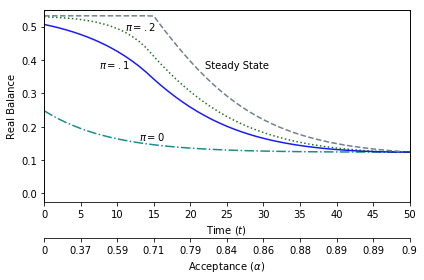

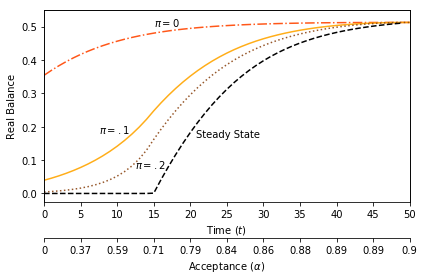

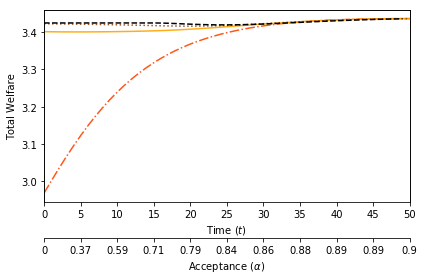

In [6]:
# See how prices change with pi

M0 = 1 # initial money supply
C0 = 1 # initial cc supply
T = 50 # maximum number of periods
t = copy(T) # period counter
pigrid = [0, .1, .2]
# pigrid = [0.05, .1, .2]

# Choose colors for each line 
m_c_grid = ['teal', 'blue', 'darkgreen']
c_c_grid = ['orangered', 'orange', 'saddlebrown']
ls_grid = ['-.', '-', ':']
c_ind = 0


# Try a different way for alpha to grow
alphatop = .9
alpha0 = 0
delta = .1 # fraction of distance from alphatop grown each period
alphagrid = [alpha0] # first alpha
# Seems to be no convenient way to do math, just use recursion
for ind in range(T):
    alphagrid.append(delta * alphatop + (1 - delta) * alphagrid[ind])
# print(alphagrid)

tgrid = range(T + 1) # count periods
Mgrid = [round(M0 * (1 + gammam) ** i, 8) for i in range(T+1)] # M supply 
Cgrid = [round(C0 * (1 + gammac) ** i, 8) for i in range(T+1)] # C supply
phigrid, psigrid, Wgrid = np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1) # Graphing growing values
phisgrid, psisgrid, Wsgrid = np.zeros(T), np.zeros(T), np.zeros(T) # Graphing stst values
qbl, qml, qbh, qmh = np.zeros(T), np.zeros(T), np.zeros(T + 1), np.zeros(T + 1) # Quantity traded
Trbphigrid, Trbpsigrid = np.zeros(T + 1), np.zeros(T + 1) # Total growing real balances 
Trbphisgrid, Trbpsisgrid = np.zeros(T), np.zeros(T) # Total stst real balances 

# Graph total real balances of money  
figtrbm, axtrbm = plt.subplots()

# Graph total real balances of cryptocurrency 
figtrbc, axtrbc = plt.subplots()

# Graph welfare
figw, axw = plt.subplots()

for pi in pigrid:
    
    t = np.copy(T) # reset period counter
    
    while t >=1 : 

        if t == T: # If in highest period, prices in high state from highest st st
            ah = alphagrid[t] # alpha in highest state
            M, C, Mp, Cp = Mgrid[t - 1], Cgrid[t - 1], Mgrid[t], Cgrid[t] # This is the last high period
            phih, psih = ststprices(ah, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in highest state
            qbhs, qmhs = ststq(ah, Mp, Cp, gammam, gammac, lam, theta, eta) # Quantities in highest state 
            Wh = ststW(ah, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Value of highest state
            phigrid[t], psigrid[t], Wgrid[t] = np.copy(phih), np.copy(psih), np.copy(Wh) # Prices if this state is reached
            Trbphigrid[t], Trbpsigrid[t] = np.copy(phih* M), np.copy(psih * C) # Total real balances if this state reached
            qbh[t], qmh[t] = np.copy(qbhs), np.copy(qmhs) # Quantities if this state reached


        t -= 1 # Working backwads
        al = alphagrid[t] # alpha in lowest state
        M, C, Mp, Cp = Mgrid[t], Cgrid[t], Mgrid[t+1], Cgrid[t+1]
        phil, psil = ststprices(al, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in lowest state
        qbl[t], qml[t] = ststq(al, Mp, Cp, gammam, gammac, lam, theta, eta) # Quantities in lowest state
        Wl = ststW(al, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Value of lowest st st
        phisgrid[t], psisgrid[t], Wsgrid[t] = copy(phil), copy(psil), copy(Wl) # If this is st st
        Trbphisgrid[t], Trbpsisgrid[t] = copy(phil* M), copy(psil * C) # If this is st st
        # Solve for today's prices/value
        phitemp, psitemp, Wtemp = nohperiod(
            M, C, 0, 0, al, phil, psil, Wl, ah, phih, psih, Wh, gammam=gammam, gammac=gammac, pi=pi) 
        phigrid[t], psigrid[t], Wgrid[t] = copy(phitemp), copy(psitemp), copy(Wtemp)
        Trbphigrid[t], Trbpsigrid[t] = copy(phih * M), copy(psih * C)
        # Look at quatinty traded in each case
        qbh[t], qmh[t] = qwealth(phih * Mp + psih * Cp), qwealth(phih * Mp)
        # Today's alpha/prices/value are yesterday's highest alpha/prices/value
        ah, phih, psih, Wh = alphagrid[t], copy(phitemp), copy(psitemp), copy(Wtemp) 
        
    # Graph    

    # Graph total real balances of money  
    axtrbm.plot(tgrid, Trbphigrid, label=f"$\pi = {pi}$", color=m_c_grid[c_ind], ls=ls_grid[c_ind], alpha=0.9)

    # Graph total real balances of cryptocurrency 
    axtrbc.plot(tgrid, Trbpsigrid, label=f"$\pi = {pi}$", color=c_c_grid[c_ind], ls=ls_grid[c_ind], alpha=0.9)
    
    # Graph welfare
    axw.plot(tgrid, Wgrid, label=f"$\pi = {pi}$", color=c_c_grid[c_ind], ls=ls_grid[c_ind], alpha=0.9)
    
    c_ind +=1
        
        
# Finish graphing

ticksize = T / 10   
xticks = [i * ticksize for i in range(11)]

# Graph total real balances of money
axtrbm.plot(tgrid[:-1], Trbphisgrid, label=r"$\bar{\phi} M$", color="slategray", linestyle="--")
axtrbm.text(22, .375, 'Steady State')
axtrbm.text(11, .49, '$\pi = .2$')
axtrbm.text(7.5, .375, '$\pi = .1$')
axtrbm.text(13, .16, '$\pi = 0$')
# axtrbm.text(13, .21, '$\pi = .05$')
# axtrbm.set_title("Money Real Balances")
axtrbm.set_xlabel(r"Time ($t$)")
axtrbm.set_xticks(xticks)
axtrbm.autoscale(enable=True, axis='x', tight=True)
axtrbm.set_ylim(-.025, .55)
axtrbm.set_ylabel(r"Real Balance")
# Make another x scale based on alpha
axtrbma = axtrbm.twiny()
axtrbma.set_xticks(xticks)
axtrbma.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axtrbma.set_xlabel(r"Acceptance ($\alpha$)")
axtrbma.xaxis.set_ticks_position('bottom')
axtrbma.xaxis.set_label_position('bottom')
axtrbma.spines['bottom'].set_position(('outward', 36))

figtrbm.tight_layout()
addm = r"\changepi\\noho" + str(T) + "periodstrbm.pdf"
figtrbm.savefig(file + addm)


# Graph total real balances of cryptocurrency 
axtrbc.plot(tgrid[:-1], Trbpsisgrid, label=r"$\bar{\psi} C$", color="black", linestyle="--")
axtrbc.text(20.75, .17, 'Steady State')
axtrbc.text(12.5, .075, '$\pi = .2$')
axtrbc.text(7.5, .18, '$\pi = .1$')
axtrbc.text(15, .5, '$\pi = 0$')
# axtrbc.text(15, .41, '$\pi = .05$')
# axtrbc.set_title("Cryptocurrency Real Balances")
axtrbc.set_xlabel(r"Time ($t$)")
axtrbc.set_xticks(xticks)
axtrbc.autoscale(enable=True, axis='x', tight=True)
axtrbc.set_ylim(-.025, .55)
axtrbc.set_ylabel(r"Real Balance")
# Make another x scale based on alpha
axtrbca = axtrbc.twiny()
axtrbca.set_xticks(xticks)
axtrbca.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axtrbca.set_xlabel(r"Acceptance ($\alpha$)")
axtrbca.xaxis.set_ticks_position('bottom')
axtrbca.xaxis.set_label_position('bottom')
axtrbca.spines['bottom'].set_position(('outward', 36))

figtrbc.tight_layout()
addc = r"\changepi\\noho" + str(T) + "periodstrbc.pdf"
figtrbc.savefig(file + addc)

# Graph welfare
axw.plot(tgrid[:-1], Wsgrid, label=r"$\bar{\psi} W$", color="black", linestyle="--")
# axw.text(21.75, .17, 'Steady State')
# axw.text(14.5, .12, '$\pi = .2$')
# axw.text(7.5, .18, '$\pi = .1$')
# axw.text(15, .5, '$\pi = 0$')
# axw.text(15, .41, '$\pi = .05$')
# axw.set_title("Cryptocurrency Real Balances")
axw.set_xlabel(r"Time ($t$)")
axw.set_xticks(xticks)
axw.autoscale(enable=True, axis='x', tight=True)
# axw.set_ylim(-.025, .55)
axw.set_ylabel(r"Total Welfare")
# Make another x scale based on alpha
axwa = axw.twiny()
axwa.set_xticks(xticks)
axwa.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axwa.set_xlabel(r"Acceptance ($\alpha$)")
axwa.xaxis.set_ticks_position('bottom')
axwa.xaxis.set_label_position('bottom')
axwa.spines['bottom'].set_position(('outward', 36))

figw.tight_layout()
addw = r"\changepi\\noho" + str(T) + "w.pdf"
figw.savefig(file + addw)

In [12]:
print(Wsgrid)

[1.71207891 1.71207891 1.71207891 1.71207891 1.71207891 1.71207891
 1.71207891 1.71207891 1.71207891 1.71207891 1.71207891 1.71207891
 1.71207891 1.71207891 1.71207891 1.71207885 1.71196085 1.7116741
 1.71129257 1.71087635 1.71047242 1.71011579 1.70983079 1.7096325
 1.70952829 1.70951927 1.70960175 1.70976849 1.71000993 1.71031512
 1.71067256 1.71107082 1.71149903 1.71194715 1.71240625 1.71286855
 1.71332747 1.71377762 1.71421465 1.71463526 1.71503697 1.71541812
 1.71577765 1.71611507 1.71643032 1.71672368 1.7169957  1.71724716
 1.71747895 1.71769209]


In [4]:
# Plot what happens as alphal, alphah, pi, and gammam all change
M = 1 
C = 1
gammam = .1
Mp = (1 + gammam) * M
Cp = (1 + gammac) * C
m, c = 0, 0
alphal = (gammac + 1 - B) / (gammam + 1 - B) + .05
alphah = (1 + alphal) / 2
pi = .1
phil, psil = ststprices(alphal, Mp, Cp, gammam, gammac, lam, theta, eta)
phih, psih = ststprices(alphah, Mp, Cp, gammam, gammac, lam, theta, eta)
Wl = ststW(alphal, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta)
Wh = ststW(alphah, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta)

alphalgrid = np.linspace(0,alphah, 101)
alphahgrid = np.linspace(alphal, .95, 101)
pigrid = np.linspace(0, 1, 101)
gammamgrid = np.linspace(0, .5, 101)

phial, psial, Wal = [], [], []
phiah, psiah, Wah = [], [], []
phipi, psipi, Wpi = [], [], []
phigm, psigm, Wgm = [], [], []

for al in alphalgrid:
    philt, psilt = ststprices(al, Mp, Cp, gammam, gammac, lam, theta, eta)
    Wlt = ststW(al, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta)
    phi, psi, W = nohperiod(M, C, m, c, al, philt, psilt, Wlt, alphah, phih, psih, Wh ,gammam=gammam, gammac=gammac, pi=pi)
    phial.append(phi), psial.append(psi), Wal.append(W)
    
for ah in alphahgrid:
    phiht, psiht = ststprices(ah, Mp, Cp, gammam, gammac, lam, theta, eta)
    Wht = ststW(ah, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta)
    phi, psi, W = nohperiod(M, C, m, c, alphal, phil, psil, Wl, ah, phiht, psiht, Wht, gammam=gammam, gammac=gammac, pi=pi)
    phiah.append(phi), psiah.append(psi), Wah.append(W)
    
for pii in pigrid:
    phi, psi, W = nohperiod(M, C, m, c, alphal, phil, psil, Wl, alphah, phih, psih, Wh, gammam=gammam, gammac=gammac, pi=pii)
    phipi.append(phi), psipi.append(psi), Wpi.append(W)
    
for gm in gammamgrid:
    Mp = (1 + gm) * M
    philt, psilt = ststprices(alphal, Mp, Cp, gm, gammac, lam, theta, eta)
    phiht, psiht = ststprices(alphah, Mp, Cp, gm, gammac, lam, theta, eta)
    Wlt = ststW(alphal, gammam=gm, gammac=gammac, lam=lam, theta=theta, eta=eta)
    Wht = ststW(alphah, gammam=gm, gammac=gammac, lam=lam, theta=theta, eta=eta)
    phi, psi, W = nohperiod(M, C, m, c, alphal, philt, psilt, Wlt, alphah, phiht, psiht, Wht, gammam=gm, gammac=gammac, pi=pi)
    phigm.append(phi), psigm.append(psi), Wgm.append(W)
    
fig1, axes1 = plt.subplots(1, 2)
axes1[0].plot(alphalgrid, phial, label=r"$\phi$")
axes1[0].plot(alphalgrid, psial, label=r"$\psi$")
axes1[0].legend()
axes1[0].set_title(r"Prices given $\alpha_l$")
axes1[0].set_xlabel(r"$\alpha_l$")
axes1[0].set_ylabel(r"Price")
axes1[0].set_xlim(0, alphah)
axes1[1].plot(alphalgrid, Wal)
axes1[1].set_title(r"Value given $\alpha_l$")
axes1[1].set_xlabel(r"$\alpha_l$")
axes1[1].set_ylabel(r"$W$")
axes1[1].set_xlim(0, alphah)

plt.tight_layout()
plt.savefig(file + r'\nohodlers\1al.pdf')
plt.close()

fig2, axes2 = plt.subplots(1, 2)
axes2[0].plot(alphahgrid, phiah, label=r"$\phi$")
axes2[0].plot(alphahgrid, psiah, label=r"$\psi$")
axes2[0].legend
axes2[0].set_title(r"Prices given $\alpha_h$")
axes2[0].set_xlabel(r"$\alpha_h$")
axes2[0].set_ylabel(r"Price")
axes2[0].set_xlim(alphal, 1)
axes2[1].plot(alphahgrid, Wah)
axes2[1].set_title(r"Value given $\alpha_h$")
axes2[1].set_xlabel(r"$\alpha_h$")
axes2[1].set_ylabel(r"$W$")
axes2[1].set_xlim(alphal, 1)

plt.tight_layout()
plt.savefig(file + r'\nohodlers\1ah.pdf')
plt.close()

fig3, axes3 = plt.subplots(1, 2)
axes3[0].plot(pigrid, phipi, label=r"$\phi$")
axes3[0].plot(pigrid, psipi, label=r"$\psi$")
axes3[0].legend
axes3[0].set_title(r"Prices given $\pi$")
axes3[0].set_xlabel(r"$\pi$")
axes3[0].set_ylabel(r"Price")
axes3[0].set_xlim(0, 1)
axes3[1].plot(pigrid, Wpi)
axes3[1].set_title(r"Value given $\pi$")
axes3[1].set_xlabel(r"$\pi$")
axes3[1].set_ylabel(r"$W$")
axes3[1].set_xlim(0, 1)

plt.tight_layout()
plt.savefig(file + r'\nohodlers\1pi.pdf')
plt.close()

fig4, axes4 = plt.subplots(1, 2)
axes4[0].plot(gammamgrid, phigm, label=r"$\phi$")
axes4[0].plot(gammamgrid, psigm, label=r"$\psi$")
axes4[0].legend
axes4[0].set_title(r"Prices given $\gamma_m$")
axes4[0].set_xlabel(r"$\gamma_m$")
axes4[0].set_ylabel(r"Price")
axes4[0].set_xlim(0, .5)
axes4[1].plot(gammamgrid, Wgm)
axes4[1].set_title(r"Value given $\gamma_m$")
axes4[1].set_xlabel(r"$\gamma_m$")
axes4[1].set_ylabel(r"$W$")
axes4[1].set_xlim(0, .5)

plt.tight_layout()
plt.savefig(file + r'\nohodlers\1gm.pdf')
plt.close()

[0.50638055 0.50160002 0.4962564  0.49030071 0.48367815 0.47632734
 0.4681795  0.45915745 0.44917467 0.43813409 0.42592681 0.41243072
 0.3975088  0.38100739 0.36275407 0.34262448 0.32357546 0.30563946
 0.28883184 0.27315246 0.25858747 0.39622166 0.39622166 0.39622166
 0.39622166 0.39622166 0.39622166 0.39622166 0.39622166 0.39622166
 0.39622166 0.39622166 0.39622166 0.39622166 0.39622166 0.39622166
 0.39622166 0.39622166 0.39622166 0.39622166 0.39622166 0.39622166
 0.39622166 0.39622166 0.39622166 0.39622166 0.39622166 0.39622166
 0.39622166 0.39622166 0.39622166] [0.03957658 0.04573098 0.05257541 0.06017304 0.06859469 0.07791984
 0.08823788 0.0996495  0.11226825 0.12622242 0.14165724 0.15873746
 0.17765051 0.1986102  0.22186141 0.24758617 0.27160829 0.293976
 0.31474154 0.33396212 0.35170016 0.18265282 0.18265282 0.18265282
 0.18265282 0.18265282 0.18265282 0.18265282 0.18265282 0.18265282
 0.18265282 0.18265282 0.18265282 0.18265282 0.18265282 0.18265282
 0.18265282 0.18265282 0.1826